In [1]:
import bitermplus as btm
import numpy as np
import pandas as pd
import statistics

def contexts_to_text(contexts):
    return " ".join([" ".join(context) + "." for context in eval(contexts)])

repos = pd.read_csv("processed_readmes_java.csv", sep=";", quotechar="'")

repos["TEXT_PROCESSED"] = repos["CONTEXTS"].transform(contexts_to_text)

texts = repos["TEXT_PROCESSED"]

X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
biterms = btm.get_biterms(docs_vec)

In [13]:
"""
In general, higher alpha values mean documents contain more similar topic contents. 
The same is true for beta, but with topics and words: generally a high beta will result in topics with more similar word contents. 
Also, an asymmetric alpha is helpful, where as an asymmetric beta is largely not.
"""

# model = btm.BTM(X, vocabulary, seed=42, T=100, M=3, alpha=1/100, beta=0.01, has_background=False)
# model.fit(biterms, iterations=1000)

print(model.perplexity_)
print(min(model.coherence_))
print(max(model.coherence_))
print(statistics.mean(model.coherence_))
print(statistics.median(model.coherence_))
print(statistics.stdev(model.coherence_)/statistics.mean(model.coherence_))

1.0
-11.698649559893719
0.6931471805599453
-4.845548728049657
-4.482823892267394
-0.5152816128515567


In [ ]:
median_coherence = statistics.median(model.coherence_)
mean_coherence = statistics.mean(model.coherence_)


for i, coherence in enumerate(model.coherence_):
    if coherence >= mean_coherence:
        print(i)

In [5]:
import optuna

def objective(trial):
    
    # alpha = trial.suggest_float("alpha", 0.02, 0.2, log=True)
    # beta = trial.suggest_float("beta", 0.005, 0.02, log=True)
    n_topic = trial.suggest_int("n_topic", 5, 50, log=False)
    # has_background = trial.suggest_categorical("has_background", [True, False])
    
    model = btm.BTM(X, vocabulary, seed=42, T=n_topic, M=20, alpha=1/n_topic, beta=0.01, has_background=False)
    model.fit(biterms, iterations=1000, verbose=False)

    return model.perplexity_

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_jobs=5, show_progress_bar=True)

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
numbers_of_topic = list(range(60, 101, 10))
perplexity_results = []
min_coherences = []
max_coherences = []
median_coherences = []

for n_topic in numbers_of_topic:
    print(n_topic)
    model = btm.BTM(X, vocabulary, seed=42, T=n_topic, M=3, alpha=1/n_topic, beta=0.01, has_background=False)
    model.fit(biterms, iterations=1000, verbose=True)
    print(model.perplexity_)
    perplexity_results.append(model.perplexity_)
    min_coherences.append(min(model.coherence_))
    max_coherences.append(max(model.coherence_))
    median_coherences.append(statistics.median(model.coherence_))
    
import plotly.express as px
fig = px.scatter(x=numbers_of_topic, y=perplexity_results)
fig.show()

60


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:33<00:00,  2.21it/s]


inf
70


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:42<00:00,  1.91it/s]


4.351504402479298e+131
80


 24%|██████████████████▋                                                            | 237/1000 [02:09<06:29,  1.96it/s]

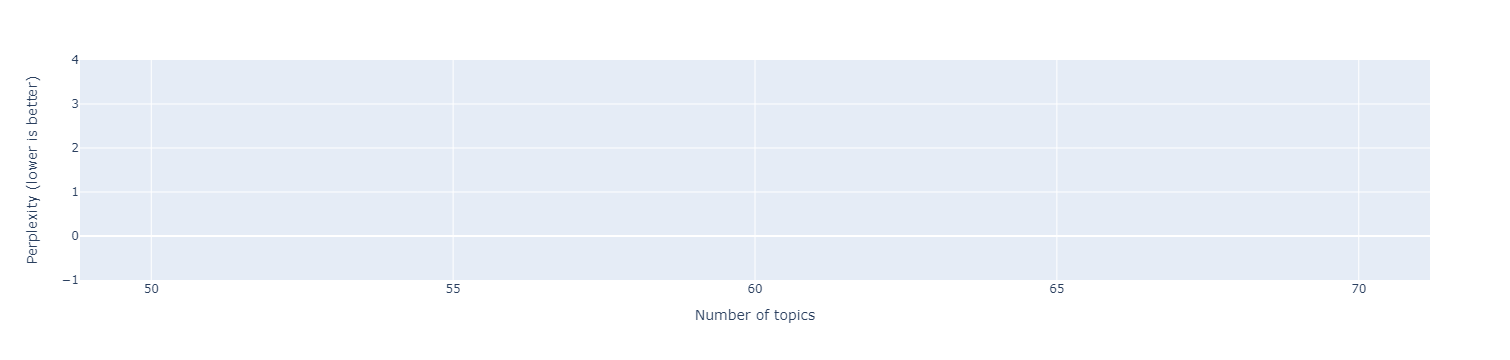

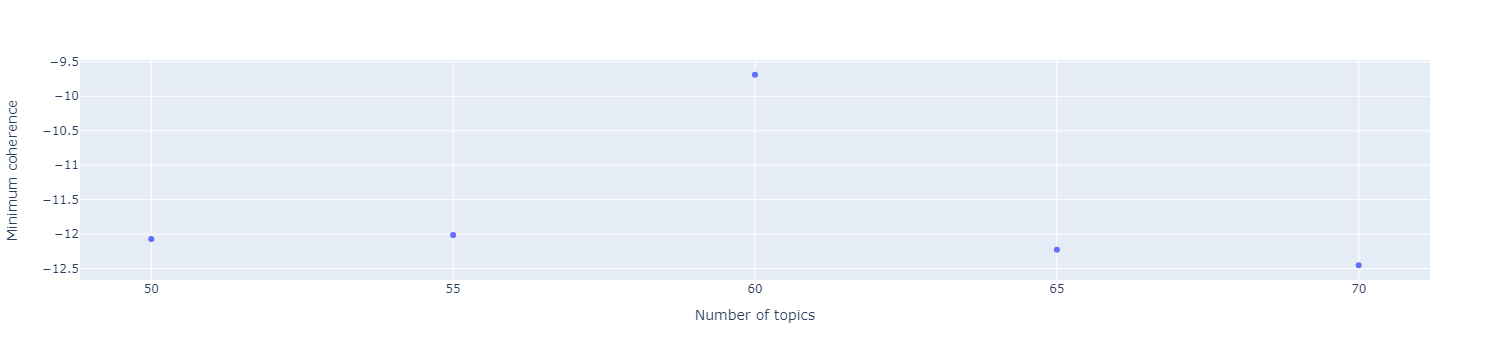

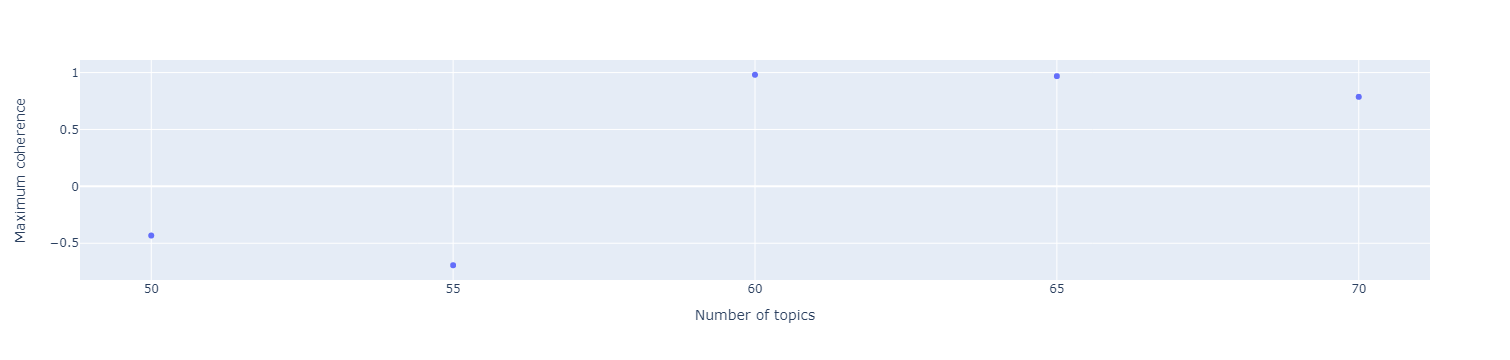

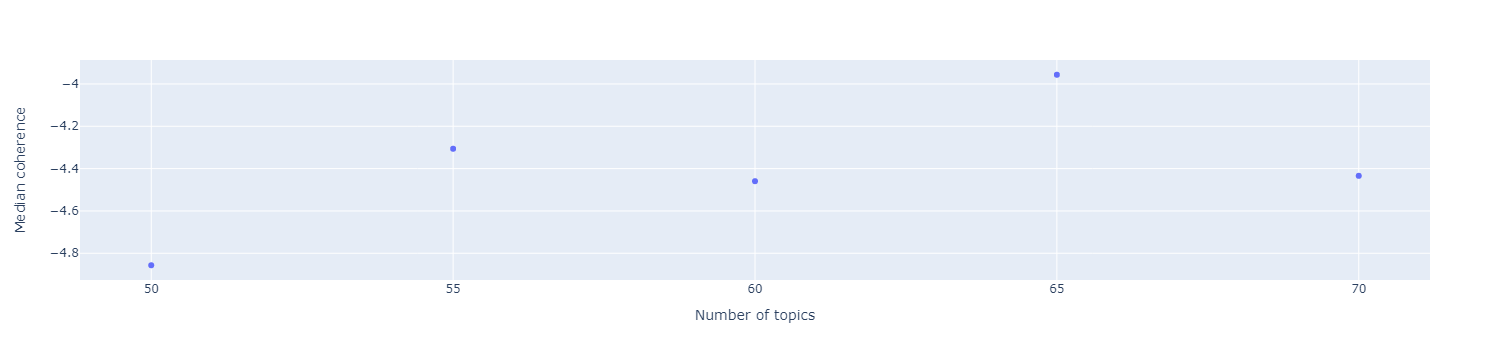

In [20]:
fig = px.scatter(x=numbers_of_topic, y=perplexity_results, log_y=False, labels={"y": "Perplexity (lower is better)", "x": "Number of topics"})
fig.show()

fig = px.scatter(x=numbers_of_topic, y=min_coherences, log_y=False, labels={"y": "Minimum coherence", "x": "Number of topics"})
fig.show()

fig = px.scatter(x=numbers_of_topic, y=max_coherences, log_y=False, labels={"y": "Maximum coherence", "x": "Number of topics"})
fig.show()

fig = px.scatter(x=numbers_of_topic, y=median_coherences, log_y=False, labels={"y": "Median coherence", "x": "Number of topics"})
fig.show()

In [58]:
p_zd = model.transform(docs_vec)

p_zd.shape

100%|███████████████████████████████████████████████████████████████████████████| 1603/1603 [00:00<00:00, 12622.73it/s]


(1603, 20)

In [8]:
import tmplot as tmp

tmp.report(model=model, docs=texts)